# Data Cleaning/Preparation for Distribution of Obesity Levels
## AAI 500 Final Group Project Fall 2024
### Group 1

## Import

Import necessary libraries and read the CSV file into a Pandas DataFrame.

In [68]:
import csv 
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import zscore


# For modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
)

df = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv')

## Missing Values

Check for missing values in the dataset. Below code output shows no missing values.

In [69]:
""" Missing Values """
# Check for missing values
missing_values = df.isnull().sum().sum()
print("Total missing values:", missing_values)

# Check for missing values in each column
missing_values_per_column = df.isnull().sum()
print("\nMissing values per column:\n", missing_values_per_column)

Total missing values: 0

Missing values per column:
 Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObesity                          0
BMI                               0
dtype: int64


## Outliers

Check for outliers, and handle as necessary by replacing outlier values with the mean of the respective data column.

In [70]:
""" Outliers """
# Select numerical columns only
numerical_columns = df.select_dtypes(include='number').columns

# Iterate over each numerical column
for column in numerical_columns:
    # Calculate Z-scores for the current column
    z_scores = zscore(df[column].dropna())

    # Define a threshold for outliers (can adjust as needed)
    threshold = 3

    # Find outliers based on threshold
    outliers_index = np.where((z_scores > threshold) | (z_scores < -threshold))[0]

    # Print outliers per column
    print(f"Outliers in {column}: {df.iloc[outliers_index][column].tolist()}")
    print(f"Count of Outliers in {column}: {len(df.iloc[outliers_index][column].tolist())}")

Outliers in Age: [52.0, 55.0, 61.0, 44.0, 55.0, 45.0, 51.0, 56.0, 45.0, 55.24625, 50.832559, 45.0, 55.137881, 46.491859, 55.022494, 47.7061, 45.821267, 43.604901, 43.510672, 47.283374, 43.591999, 43.719395, 43.37634, 43.726081]
Count of Outliers in Age: 24
Outliers in Height: []
Count of Outliers in Height: 0
Outliers in Weight: []
Count of Outliers in Weight: 0
Outliers in FCVC: []
Count of Outliers in FCVC: 0
Outliers in NCP: []
Count of Outliers in NCP: 0
Outliers in CH2O: []
Count of Outliers in CH2O: 0
Outliers in FAF: []
Count of Outliers in FAF: 0
Outliers in TUE: []
Count of Outliers in TUE: 0
Outliers in BMI: []
Count of Outliers in BMI: 0


Graphical depiction of outliers using box plots, for illustrative purposes.

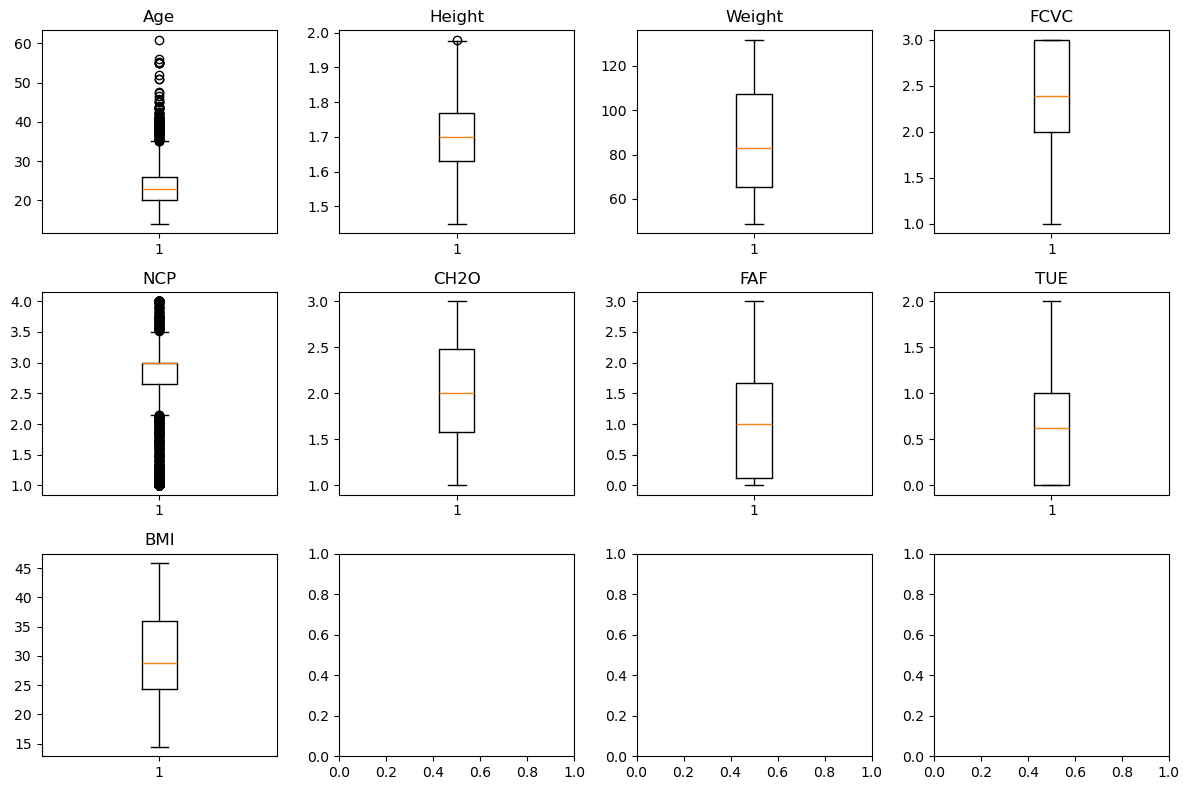

In [71]:
# Select numerical columns
numerical_columns = df.select_dtypes(include='number').columns

# Create individual box plots for each numerical column of data
fig, axes = plt.subplots(nrows=int(np.ceil(len(numerical_columns) / 4)), ncols=4, figsize=(12, 8))

for i, column in enumerate(numerical_columns):
    row, col = i // 4, i % 4
    axes[row, col].boxplot(df[column])
    axes[row, col].set_title(column)

plt.tight_layout()
plt.show()

'Age' appears to be right-skewed. It is certainly not normal, corroborated by the histogram and Shapiro-Wilk test, which output a very small p-value.

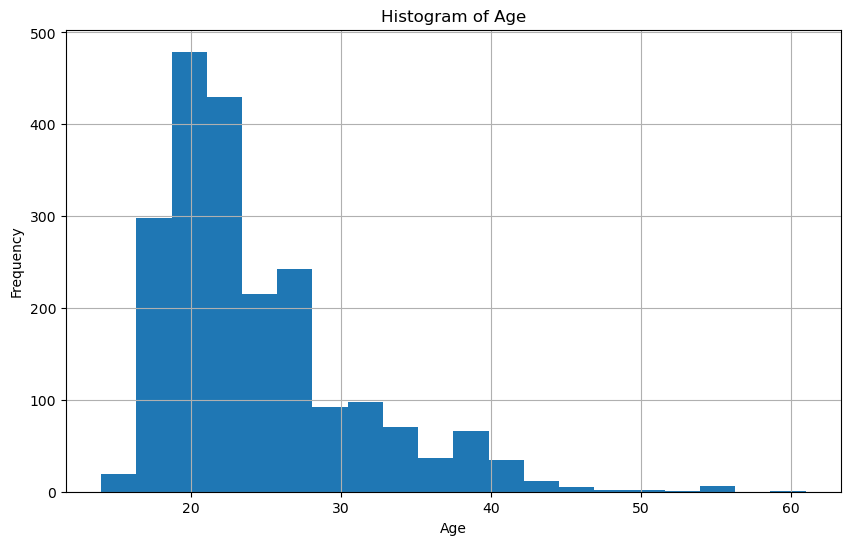

Shapiro-Wilk Test:
Statistic: 0.866
P-value: 3.5182779187666774e-39


In [72]:
# Histogram of Age column
plt.figure(figsize=(10, 6))
df['Age'].plot.hist(bins=20)  # Adjust the number of bins as needed
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Shapiro-Wilk test for normality
statistic, p_value = stats.shapiro(df['Age'])
print("Shapiro-Wilk Test:")
print("Statistic:", round(statistic,3))
print("P-value:", p_value) 

# Output:
# Statistic: 0.866
# P-value: 3.518277918766476e-39
# Data is not normally distributed.

Replace or otherwise handle outliers. As shown above, there are 24 outliers in 'Age' and 1 outlier in 'Weight'. 'Age' outliers will not be altered as age is right skewed, so these outliers likely come with the respective distribution.

As a result of the 'Weight' outlier, the column will be winsorized. This replaces the 5% of the lowest and highest values with the 5th and 95th percentiles, respectively. The boxplot of the winsorized 'Weight' column values shows no outliers; compare with the same boxplot of 'Weight' before winsorization, which showed a large outlier.

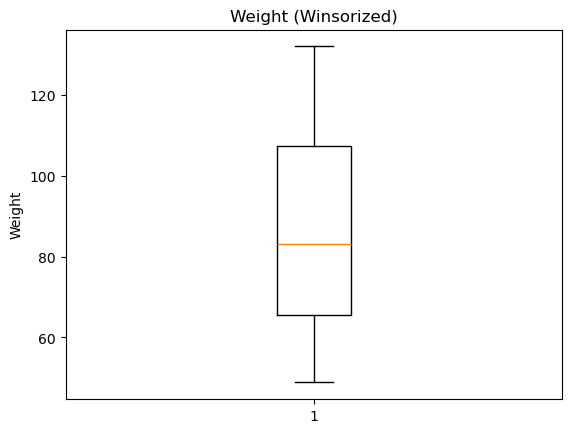

In [73]:
# Winsorize 'Weight' column
winsorized_weight = df['Weight'].clip(lower=df['Weight'].quantile(0.05), upper=df['Weight'].quantile(0.95))

# Replace original 'Weight' column with winsorized version
df['Weight'] = winsorized_weight

# Write to datafile
df.to_csv('ObesityDataSet_raw_and_data_sinthetic.csv', index=False)

# Boxplot of 'Weight'
plt.boxplot(df['Weight'])
plt.title('Weight (Winsorized)')
plt.ylabel('Weight')
plt.show()



## Categorical Variables

Check categorical variables to ensure data consistency, and standardize if needed. All categorical values in this dataset are consistent, corroborated by the code and output below.

In [74]:
""" Categorical variables """
# Ensure categorical variables are consistent in spelling

# Select categorical columns
categorical_columns = df.select_dtypes(include='object').columns

# Check for unique values in each categorical column
for column in categorical_columns:
    unique_values = df[column].unique()
    print(f"\nUnique values in {column}:")  

    print(unique_values)

    # Check for inconsistencies (e.g., typos, capitalization)
    if len(unique_values) > df[column].nunique():
        print("Inconsistent values found in", column)


Unique values in Gender:
['Female' 'Male']

Unique values in family_history_with_overweight:
['yes' 'no']

Unique values in FAVC:
['no' 'yes']

Unique values in CAEC:
['Sometimes' 'Frequently' 'Always' 'no']

Unique values in SMOKE:
['no' 'yes']

Unique values in SCC:
['no' 'yes']

Unique values in CALC:
['no' 'Sometimes' 'Frequently' 'Always']

Unique values in MTRANS:
['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']

Unique values in NObesity:
['Normal_Weight' 'Overweight_Level_I' 'Overweight_Level_II'
 'Obesity_Type_I' 'Insufficient_Weight' 'Obesity_Type_II'
 'Obesity_Type_III']


## Feature Engineering

Create new features for body-mass index (BMI), or others as needed.
BMI, specifically, is what feeds into the categories of obesity levels (underweight, normal, overweight, etc.)

In [75]:
""" Feature engineering """
# Calculate BMI
df['BMI'] = df['Weight'] / (df['Height'] ** 2)

# Write the updated DataFrame back to the CSV file (add BMI column to datafile csv)
df.to_csv("ObesityDataSet_raw_and_data_sinthetic.csv", index=False)

# Descriptive statistics

In [76]:
print("\nDescriptive Statistics:")
print(df.describe())


Descriptive Statistics:
               Age       Height       Weight         FCVC          NCP  \
count  2111.000000  2111.000000  2111.000000  2111.000000  2111.000000   
mean     24.312600     1.701677    86.475233     2.419043     2.685628   
std       6.345968     0.093305    24.928077     0.533927     0.778039   
min      14.000000     1.450000    48.875000     1.000000     1.000000   
25%      19.947192     1.630000    65.473343     2.000000     2.658738   
50%      22.777890     1.700499    83.000000     2.385502     3.000000   
75%      26.000000     1.768464   107.430682     3.000000     3.000000   
max      61.000000     1.980000   131.905981     3.000000     4.000000   

              CH2O          FAF          TUE          BMI  
count  2111.000000  2111.000000  2111.000000  2111.000000  
mean      2.008011     1.010298     0.657866    29.692563  
std       0.612953     0.850592     0.608927     7.635819  
min       1.000000     0.000000     0.000000    14.436141  
25%     

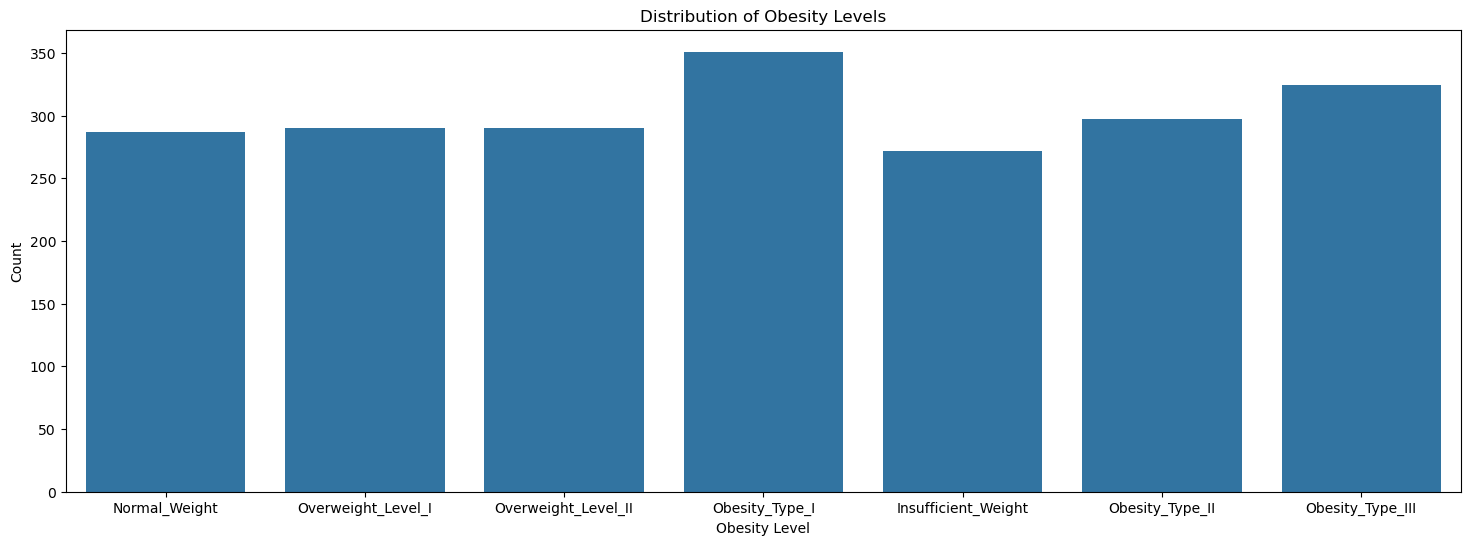

In [77]:
# Visualize the distribution of obesity levels
plt.figure(figsize=(18,6))
sns.countplot(data=df, x='NObesity')
plt.title('Distribution of Obesity Levels')
plt.xlabel('Obesity Level')
plt.ylabel('Count')
plt.show()

# Encode categorical variables

In [78]:

categorical_cols = [
    'Gender', 'family_history_with_overweight', 'FAVC', 'CAEC',
    'SMOKE', 'SCC', 'CALC', 'MTRANS'
]

In [79]:
# Initialize LabelEncoder
le = LabelEncoder()

for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

In [80]:
# Encode target variable
df['NObesity'] = le.fit_transform(df['NObesity'])


In [81]:
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObesity,BMI
0,0,21.0,1.62,64.0,1,0,2.0,3.0,2,0,2.0,0,0.0,1.0,3,3,1,24.386526
1,0,21.0,1.52,56.0,1,0,3.0,3.0,2,1,3.0,1,3.0,0.0,2,3,1,24.238227
2,1,23.0,1.80,77.0,1,0,2.0,3.0,2,0,2.0,0,2.0,1.0,1,3,1,23.765432
3,1,27.0,1.80,87.0,0,0,3.0,3.0,2,0,2.0,0,2.0,0.0,1,4,5,26.851852
4,1,22.0,1.78,89.8,0,0,2.0,1.0,2,0,2.0,0,0.0,0.0,2,3,6,28.342381


In [82]:
# Feature and target separation
X = df.drop('NObesity', axis=1)
y = df['NObesity']

## Test Train Split

In [83]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [84]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# LogisticRegression and Random Forest

In [85]:
# Initialize models
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [86]:
# Train Logistic Regression
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [87]:
# Train Random Forest
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

# Model Evaluation and Comparison

In [88]:
# Predictions
y_pred_log = log_reg.predict(X_test_scaled)
y_pred_rf = rf_clf.predict(X_test)

# Accuracy Scores
acc_log = accuracy_score(y_test, y_pred_log)
acc_rf = accuracy_score(y_test, y_pred_rf)

In [89]:
print(f"\nLogistic Regression Accuracy: {acc_log:.4f}")
print(f"Random Forest Classifier Accuracy: {acc_rf:.4f}")

# Classification Report for Logistic Regression
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log))

# Classification Report for Random Forest
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))



Logistic Regression Accuracy: 0.9078
Random Forest Classifier Accuracy: 0.9882

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.93      0.88        54
           1       0.82      0.72      0.77        58
           2       0.96      0.96      0.96        70
           3       0.97      1.00      0.98        60
           4       1.00      0.98      0.99        65
           5       0.81      0.88      0.84        58
           6       0.93      0.86      0.89        58

    accuracy                           0.91       423
   macro avg       0.90      0.90      0.90       423
weighted avg       0.91      0.91      0.91       423


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        54
           1       0.97      0.98      0.97        58
           2       0.99      1.00      0.99        70
           3       0.98 

# Confusion Matrix for Logistic Regression

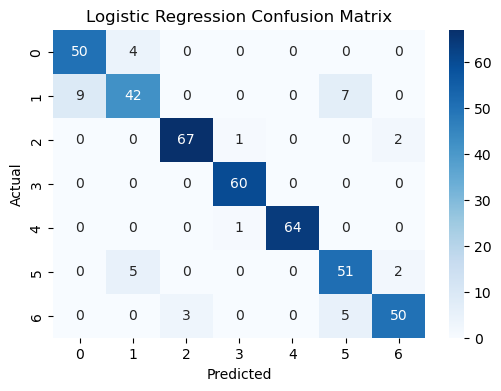

In [91]:
cm_log = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(6,4))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Confusion Matrix for Random Forest

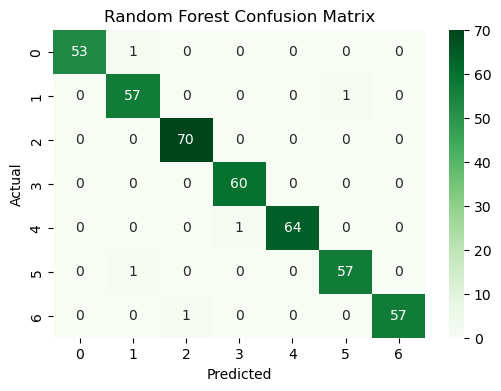

In [92]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens')
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [93]:
# ROC Curve and AUC for Logistic Regression (One-vs-Rest)
y_prob_log = log_reg.predict_proba(X_test_scaled)
roc_auc_log = roc_auc_score(pd.get_dummies(y_test), y_prob_log, multi_class='ovr')
print(f"Logistic Regression ROC AUC Score: {roc_auc_log:.4f}")

Logistic Regression ROC AUC Score: 0.9910


In [94]:
# ROC Curve and AUC for Random Forest (One-vs-Rest)
y_prob_rf = rf_clf.predict_proba(X_test)
roc_auc_rf = roc_auc_score(pd.get_dummies(y_test), y_prob_rf, multi_class='ovr')

print(f"Random Forest ROC AUC Score: {roc_auc_rf:.4f}")

Random Forest ROC AUC Score: 0.9999


# Feature Importance from Random Forest

In [95]:
importances = rf_clf.feature_importances_
feature_names = X.columns
feature_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)


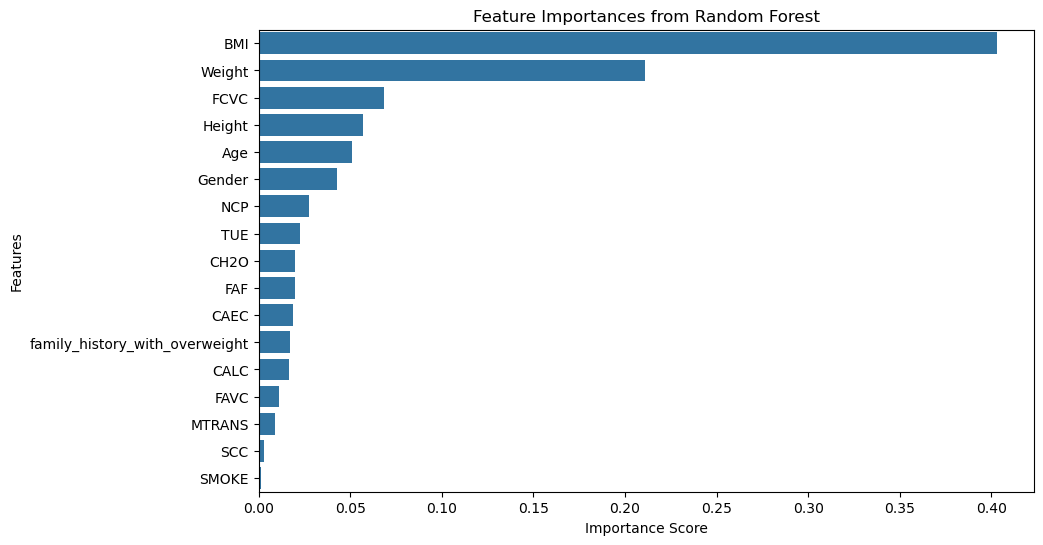

In [96]:
plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

In [97]:
# Cross-Validation Scores
cv_scores_log = cross_val_score(log_reg, scaler.fit_transform(X), y, cv=5, scoring='accuracy')
cv_scores_rf = cross_val_score(rf_clf, X, y, cv=5, scoring='accuracy')

print(f"\nLogistic Regression Cross-Validation Accuracy: {cv_scores_log.mean():.4f} ± {cv_scores_log.std():.4f}")
print(f"Random Forest Cross-Validation Accuracy: {cv_scores_rf.mean():.4f} ± {cv_scores_rf.std():.4f}")



Logistic Regression Cross-Validation Accuracy: 0.8959 ± 0.0790
Random Forest Cross-Validation Accuracy: 0.9697 ± 0.0417


# Summary of Model Comparison

In [98]:
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [acc_log, acc_rf],
    'ROC AUC': [roc_auc_log, roc_auc_rf],
    'Cross-Val Mean Accuracy': [cv_scores_log.mean(), cv_scores_rf.mean()],
    'Cross-Val Std': [cv_scores_log.std(), cv_scores_rf.std()]
})

print("\nModel Comparison:")
print(comparison_df)


Model Comparison:
                 Model  Accuracy   ROC AUC  Cross-Val Mean Accuracy  \
0  Logistic Regression  0.907801  0.990993                 0.895858   
1        Random Forest  0.988180  0.999926                 0.969722   

   Cross-Val Std  
0       0.079047  
1       0.041733  
